# Propagation with the GMAT API 
This document walks you through the configuration and use of the GMAT API for propagation.

## Prepare the GMAT Environment
Before the API can be used, it needs to be loaded into the Python system and initialized using a GMAT startup file. This can be done from the GMAT bin folder by importing the gmatpy module, but using that approach tends to leave files in the bin folder that may annoy other users. Running from an outside folder takes a few steps, which have been captured in the load_gmat.py file in the GMAT api folder. After preparing the API for use (see the API "read me" file, api/API_README.txt), copy load_gmat.py into the folder you are using for Jupyter notebooks. Then import it:

In [15]:
import sys
sys.path.insert(1, r'C:\\Users\\phili.000\\PhysNum\\gmat\\GMAT\\api')
from load_gmat import *
import matplotlib.pyplot as plt

## Configure a Spacecraft
We'll need a spacecraft to propagate.  The following lines provide a basic Spacecraft configuration:

In [22]:
sat = gmat.Construct("Spacecraft","LeoSat")

sat.SetField("DateFormat", "UTCGregorian")
sat.SetField("Epoch", "12 Mar 2020 15:00:00.000")
sat.SetField("CoordinateSystem", "EarthMJ2000Eq")
sat.SetField("DisplayStateType", "Keplerian")
sat.SetField("SMA", 7005)
sat.SetField("ECC", 0.008)
sat.SetField("INC", 28.5)
sat.SetField("RAAN", 75)
sat.SetField("AOP", 90)
sat.SetField("TA", 45)

sat.SetField("DryMass", 50)
sat.SetField("Cd", 2.2)
sat.SetField("Cr", 1.8)
sat.SetField("DragArea", 1.5)
sat.SetField("SRPArea", 1.2)

<function Construct at 0x000002B7D6C33E50>


## Configure the Forces
Next we'll set up a force model.  For this example, we'll use an Earth 8x8 potential model, with Sun and Moon point masses and Jacchia-Roberts drag.  In GMAT, forces are collected in the ODEModel class.  That class is scripted as a "ForceModel" in the script language.  The API accepts either.  The force model is built and its (empty) contents displayed using

In [17]:
fm = gmat.Construct("ForceModel", "TheForces")
fm.Help()


ForceModel  TheForces

   Field                                   Type   Value
   --------------------------------------------------------

   CentralBody                           Object   Earth
   PrimaryBodies                    ObjectArray   {Earth}
   PolyhedralBodies                 ObjectArray   {}
   PointMasses                      ObjectArray   {Luna, Sun}
   Drag                                  Object   JacchiaRoberts
   SRP                                    OnOff   Off
   RelativisticCorrection                 OnOff   Off
   ErrorControl                            List   RSSStep
   UserDefined                      ObjectArray   {}



''

## Add the Potential Field
In this example, the spacecraft is in Earth orbit.  The largest force for the model is the Earth gravity field.  We'll set it to an 8x8 field and add it to the force model using the code

In [18]:
# An 8x8 JGM-3 Gravity Model
earthgrav = gmat.Construct("GravityField")
earthgrav.SetField("BodyName","Earth")
earthgrav.SetField("Degree",8)
earthgrav.SetField("Order",8)
earthgrav.SetField("PotentialFile","JGM2.cof")

# Add forces into the ODEModel container
fm.AddForce(earthgrav)

APIException: ODEModel Exception Thrown: Attempted to add a GravityField force to the force model for the body Earth, but there is already a GravityField force in place for that body.

## Add the other forces
Next we'll build and add the Sun, Moon, and Drag forces, and then show the completed force model.

In [ ]:
# The Point Masses
moongrav = gmat.Construct("PointMassForce")
moongrav.SetField("BodyName","Luna")
sungrav = gmat.Construct("PointMassForce")
sungrav.SetField("BodyName","Sun")

# Drag using Jacchia-Roberts
jrdrag = gmat.Construct("DragForce")
jrdrag.SetField("AtmosphereModel","JacchiaRoberts")

# Build and set the atmosphere for the model
atmos = gmat.Construct("JacchiaRoberts")
jrdrag.SetReference(atmos)

# Add all of the forces into the ODEModel container
fm.AddForce(moongrav)
fm.AddForce(sungrav)
fm.AddForce(jrdrag)

fm.Help()


ForceModel  TheForces

   Field                                   Type   Value
   --------------------------------------------------------

   CentralBody                           Object   Earth
   PrimaryBodies                    ObjectArray   {Earth}
   PolyhedralBodies                 ObjectArray   {}
   PointMasses                      ObjectArray   {Luna, Sun}
   Drag                                  Object   JacchiaRoberts
   SRP                                    OnOff   Off
   RelativisticCorrection                 OnOff   Off
   ErrorControl                            List   RSSStep
   UserDefined                      ObjectArray   {}



''

In GMAT, the force model scripting shows the settings for each force.  In the API, you can examine the settings for the individual forces:

In [ ]:
earthgrav.Help()


GravityField  

   Field                                   Type   Value
   --------------------------------------------------------

   Degree                               Integer   8
   Order                                Integer   8
   StmLimit                             Integer   100
   PotentialFile                       Filename   JGM2.cof
   TideFile                            Filename   
   TideModel                             String   None



''

or, with a little work, the GMAT scripting for the complete force model:

In [ ]:
print(fm.GetGeneratingString(0))

Create ForceModel TheForces;
GMAT TheForces.CentralBody = Earth;
GMAT TheForces.PrimaryBodies = {Earth};
GMAT TheForces.PointMasses = {Luna, Sun};
GMAT TheForces.SRP = Off;
GMAT TheForces.RelativisticCorrection = Off;
GMAT TheForces.ErrorControl = RSSStep;
GMAT TheForces.GravityField.Earth.Degree = 8;
GMAT TheForces.GravityField.Earth.Order = 8;
GMAT TheForces.GravityField.Earth.StmLimit = 100;
GMAT TheForces.GravityField.Earth.PotentialFile = 'JGM2.cof';
GMAT TheForces.GravityField.Earth.TideModel = 'None';
GMAT TheForces.Drag.AtmosphereModel = JacchiaRoberts;
GMAT TheForces.Drag.HistoricWeatherSource = 'ConstantFluxAndGeoMag';
GMAT TheForces.Drag.PredictedWeatherSource = 'ConstantFluxAndGeoMag';
GMAT TheForces.Drag.CSSISpaceWeatherFile = 'SpaceWeather-All-v1.2.txt';
GMAT TheForces.Drag.SchattenFile = 'SchattenPredict.txt';
GMAT TheForces.Drag.F107 = 150;
GMAT TheForces.Drag.F107A = 150;
GMAT TheForces.Drag.MagneticIndex = 3;
GMAT TheForces.Drag.SchattenErrorModel = 'Nominal';
GMAT Th

## Configure the Integrator
Finally, in order to propagate, we need an integrator.  For this example, we'll use a Prince-Dormand 7(8) Runge-Kutta integrator.  The propagator is set using the code

In [ ]:
# Build the propagation container that connect the integrator, force model, and spacecraft together
pdprop = gmat.Construct("Propagator","PDProp")

# Create and assign a numerical integrator for use in the propagation
gator = gmat.Construct("PrinceDormand78", "Gator")
pdprop.SetReference(gator)

# Set some of the fields for the integration
pdprop.SetField("InitialStepSize", 60.0)
pdprop.SetField("Accuracy", 1.0e-12)
pdprop.SetField("MinStep", 0.0)

## Connect the Objects Together
Next the propagator needs its assigned force.  This assignment is made by passing the force model to the propagator: 

In [ ]:
# Assign the force model to the propagator
pdprop.SetReference(fm)

True

It also need to know the object that is propagated.  For this example, that is the spacecraft constructed above:

In [ ]:
pdprop.AddPropObject(sat)

## Initialize the System and Propagate a Step
Finally, the system can be initialized and fired to see a single propagation step.  Some of the code displayed here will be folded into the API's Initialize() function.  For now, the steps needed to initialize the system for a propagation step are:

In [ ]:
# Perform top level initialization
gmat.Initialize()
# Perform the integation subsysem initialization
pdprop.PrepareInternals()

# Refresh the integrator reference
gator = pdprop.GetPropagator()

and we can then propagate, and start accumulating the data

In [ ]:
# Take a 60 second step, showing the state before and after, and start buffering
# Buffers for the data
time = []
pos = []
vel = []

gatorstate = gator.GetState()
t = 0.0
r = []
v = []
for j in range(3):
    r.append(gatorstate[j])
    v.append(gatorstate[j+3])
time.append(t)
pos.append(r)
vel.append(v)

print("Starting state:\n", t, r, v)

# Take a step and buffer it
gator.Step(60.0)
gatorstate = gator.GetState()
t = t + 60.0
r = []
v = []
for j in range(3):
    r.append(gatorstate[j])
    v.append(gatorstate[j+3])
time.append(t)
pos.append(r)
vel.append(v)

print("Propped state:\n", t, r, v)

Starting state:
 0.0 [-5455.495852919224, -3637.0485868833093, 2350.0571814448517] [3.1318014092807553, -6.42394062754871, -2.5452275734176575]
Propped state:
 60.0 [-5256.138189375633, -4014.490401475754, 2192.448780651786] [3.5110370536055036, -6.153046715326809, -2.706493532041117]


Finally, we can run for a few orbits and show the results

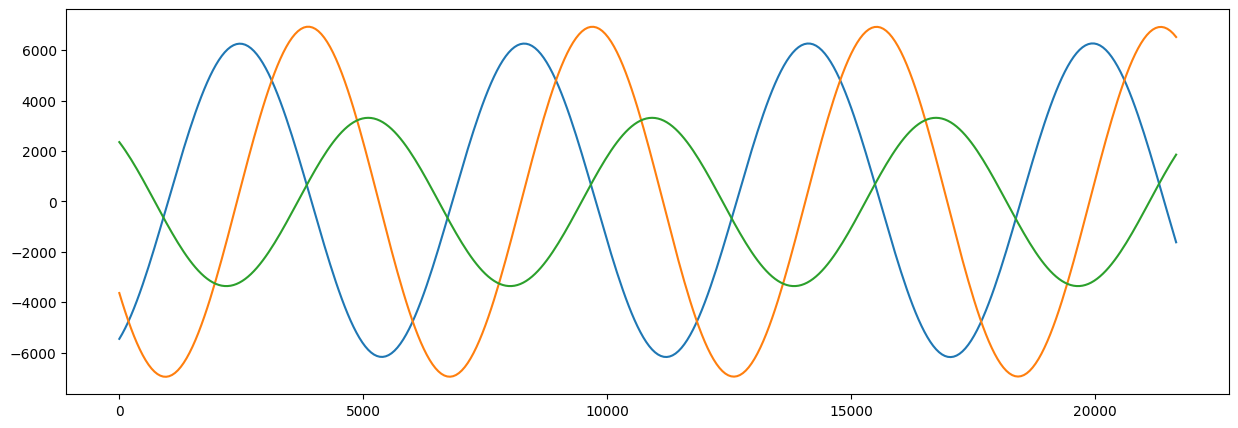

In [ ]:
for i in range(360):
    # Take a step and buffer it
    gator.Step(60.0)
    gatorstate = gator.GetState()
    t = t + 60.0
    r = []
    v = []
    for j in range(3):
        r.append(gatorstate[j])
        v.append(gatorstate[j+3])
    time.append(t)
    pos.append(r)
    vel.append(v)

plt.rcParams['figure.figsize'] = (15, 5)
positions = plt.plot(time, pos)

The velocities can also be plotted:

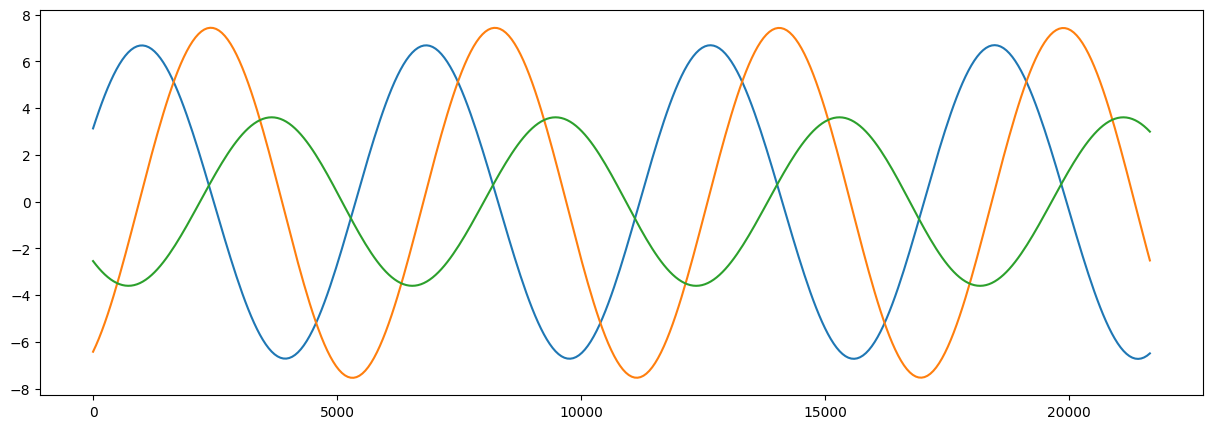

In [ ]:
velocities = plt.plot(time, vel)